<a href="https://colab.research.google.com/github/vlad-uve/CAE-MNIST/blob/main/notebooks/CAE_tradeoff_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Clone Git Repo

In [ ]:
from getpass import getpass

token = getpass("Paste your GitHub token")

user_name = 'vlad-uve'
repo_name = 'CAE-MNIST'
repo_url = f"https://{token}@github.com/{user_name}/{repo_name}.git"

!git config --global user.email "vladislav.yushkevich.uve@gmail.com"
!git config --global user.name "vlad_uve"

!git clone {repo_url}

#Append system path
import sys
sys.path.append('/content/CAE-MNIST')

Paste your GitHub token··········
Cloning into 'CAE-MNIST'...
remote: Enumerating objects: 685, done.
remote: Counting objects: 100% (218/218), done.
remote: Compressing objects: 100% (189/189), done.
remote: Total 685 (delta 122), reused 75 (delta 29), pack-reused 467 (from 1)
Receiving objects: 100% (685/685), 22.76 MiB | 21.23 MiB/s, done.
Resolving deltas: 100% (353/353), done.


In [ ]:
# import core model components
from src.model import AutoEncoder, Encoder, Decoder

# import training utilities
from src.train import train_model, validate_model, run_model_training

# import data loading functions
from src.data import get_train_dataloader, get_validation_dataloader

# import evaluation helpers
from src.evaluation import get_experiment_reconstructions, get_image_samples

# import plotting functions
from src.plotting import plot_digits_row, plot_experiment_reconstructions, plot_experiment_history, disply_reconstruction_images

# import exporting functions
from src.export import save_experiment_files, export_experiment_files

In [ ]:
# OS and file utilities
import os
import shutil

# PyTorch core modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Data loading and transformations
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Model summary utility
from torchsummary import summary

# Learning rate scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Plotting
import matplotlib.pyplot as plt

# Import utility to display images directly in notebook
from IPython.display import Image, display

In [ ]:
# set device to GPU if available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# set random seed for reproducibility
torch.manual_seed(0)

## Define New Class

In [ ]:
class ShallowEncoder(Encoder):
    def _build_layers(self):
        # 2-layer encoder architecture
        self.encn1 = nn.Conv2d(1, self.n_channels[0], self.kernel[0], self.stride, self.padding)
        self.encn2 = nn.Conv2d(self.n_channels[0], self.n_channels[1], self.kernel[1], self.stride, self.padding)

        # optional batch normalization layers after each conv
        if self.use_batch_norm:
            self.bn1 = nn.BatchNorm2d(self.n_channels[0])
            self.bn2 = nn.BatchNorm2d(self.n_channels[1])
        else:
            self.bn1 = self.bn2 = nn.Identity()

        # flatten and fully connected bottleneck layer
        # assumes output is 7x7 after 2 conv layers on 28x28 input
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(self.n_channels[1] * 7 * 7, self.latent_dim)

    def forward(self, input_x):
        x = self.apply_activation(self.bn1(self.encn1(input_x)))
        x = self.apply_activation(self.bn2(self.encn2(x)))
        return self.fc1(self.flatten(x))



class ShallowDecoder(Decoder):
    def _build_layers(self):
        # fully connected + unflatten to prepare for decoding
        self.fc1 = nn.Linear(self.latent_dim, self.n_channels[1] * 7 * 7)
        self.unflatten = nn.Unflatten(1, (self.n_channels[1], 7, 7))

        # 2-layer decoder architecture (reverse of encoder)
        self.decn1 = nn.ConvTranspose2d(self.n_channels[1], self.n_channels[0], self.kernel[1], self.stride, self.padding)
        self.decn2 = nn.ConvTranspose2d(self.n_channels[0], 1, self.kernel[0], self.stride, self.padding)

        # optional batch normalization
        if self.use_batch_norm:
            self.bn1 = nn.BatchNorm2d(self.n_channels[1])
        else:
            self.bn1 = nn.Identity()

    def forward(self, encoded):
        x = self.unflatten(self.fc1(encoded))
        x = self.apply_activation(self.bn1(self.decn1(x)))
        x = self.decn2(x)
        return torch.sigmoid(x)  # use torch.sigmoid, not F.sigmoid



class ShallowAutoEncoder(nn.Module):
    def __init__(self, n_channels, latent_dim, use_batch_norm=False, activation_func='relu', leaky_relu_slope=0.2):
        super(ShallowAutoEncoder, self).__init__()

        kernel = [4, 4]
        stride = 2
        padding = 1

        self.encoder = ShallowEncoder(n_channels, latent_dim, kernel, stride, padding,
                                      use_batch_norm, activation_func, leaky_relu_slope)
        self.decoder = ShallowDecoder(n_channels, latent_dim, kernel, stride, padding,
                                      use_batch_norm, activation_func, leaky_relu_slope)

    def forward(self, input_x):
        encoded_x = self.encoder(input_x)
        decoded_x = self.decoder(encoded_x)
        return decoded_x, encoded_x

In [ ]:
# define trade-off model parameters
tradeoff_n_channels = [32, 32]
tradeoff_latent_dim = 16
tradeoff_train_batch_size = 32
tradeoff_validation_batch_size = 500
tradeoff_num_epoch = 20

# initialize dataloaders for the trade-off model
tradeoff_train_dataloader = get_train_dataloader(
    batch_size=tradeoff_train_batch_size,
    data_dir='../data'
)

tradeoff_validation_dataloader = get_validation_dataloader(
    batch_size=tradeoff_validation_batch_size,
    data_dir='../data'
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 493kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.55MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.08MB/s]


In [ ]:
tradeoff_model = ShallowAutoEncoder(
    n_channels=tradeoff_n_channels,
    latent_dim=tradeoff_latent_dim
).to(device)

tradeoff_optimizer = optim.Adam(tradeoff_model.parameters(), lr=1e-3)
tradeoff_scheduler = ReduceLROnPlateau(tradeoff_optimizer, mode='min', threshold=1e-4, patience=3, factor=0.5)

In [ ]:
print(summary(tradeoff_model, input_size=(1,28,28)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]             544
          Identity-2           [-1, 32, 14, 14]               0
            Conv2d-3             [-1, 32, 7, 7]          16,416
          Identity-4             [-1, 32, 7, 7]               0
           Flatten-5                 [-1, 1568]               0
            Linear-6                   [-1, 16]          25,104
    ShallowEncoder-7                   [-1, 16]               0
            Linear-8                 [-1, 1568]          26,656
         Unflatten-9             [-1, 32, 7, 7]               0
  ConvTranspose2d-10           [-1, 32, 14, 14]          16,416
         Identity-11           [-1, 32, 14, 14]               0
  ConvTranspose2d-12            [-1, 1, 28, 28]             513
   ShallowDecoder-13            [-1, 1, 28, 28]               0
Total params: 85,649
Trainable params: 

In [ ]:
# define trade-off model description: balanced configuration
tradeoff_model_description = """
Trade-off Model: lightweight CAE configuration based on experimental findings

Final architecture:
- Number of encoding/decoding layers: 2
- Convolutional filters: [32, 32]
- Latent dimension: 16
- Activation function: ReLU
- Batch Normalization: None
- Optimizer: Adam (lr = 1e-3)
- Scheduler: ReduceLROnPlateau (patience = 3, factor = 0.5, threshold = 1e-3)
- Training epochs: 20
- Train batch size: 32
- Validation batch size: 500

"""
print(tradeoff_model_description.strip())

Trade-off Model: lightweight CAE configuration based on experimental findings

Final architecture:
- Number of encoding/decoding layers: 2
- Convolutional filters: [32, 32]
- Latent dimension: 16
- Activation function: ReLU
- Batch Normalization: None
- Optimizer: Adam (lr = 1e-3)
- Scheduler: ReduceLROnPlateau (patience = 3, factor = 0.5, threshold = 1e-3)
- Training epochs: 20
- Train batch size: 32
- Validation batch size: 500


In [ ]:
# train model
tradeoff_model, tradeoff_loss = run_model_training(
    model=tradeoff_model,
    train_dataloader=tradeoff_train_dataloader,
    validation_dataloader=tradeoff_validation_dataloader,
    optimizer=tradeoff_optimizer,
    scheduler=tradeoff_scheduler,
    num_epoch=tradeoff_num_epoch,
    device=device
)


TRAINING IS STARTED:
Epoch  1 | Train Loss: 0.0956 | Validation Loss: 0.0988
Epoch  2 | Train Loss: 0.0924 | Validation Loss: 0.0935
Epoch  3 | Train Loss: 0.1045 | Validation Loss: 0.0907
Epoch  4 | Train Loss: 0.0885 | Validation Loss: 0.0894
Epoch  5 | Train Loss: 0.0933 | Validation Loss: 0.0888
Epoch  6 | Train Loss: 0.0853 | Validation Loss: 0.0878
Epoch  7 | Train Loss: 0.0857 | Validation Loss: 0.0874
Epoch  8 | Train Loss: 0.0904 | Validation Loss: 0.0870
Epoch  9 | Train Loss: 0.0820 | Validation Loss: 0.0865
Epoch 10 | Train Loss: 0.0921 | Validation Loss: 0.0864
Epoch 11 | Train Loss: 0.0823 | Validation Loss: 0.0861
Epoch 12 | Train Loss: 0.0905 | Validation Loss: 0.0860
Epoch 13 | Train Loss: 0.0888 | Validation Loss: 0.0856
Epoch 14 | Train Loss: 0.0902 | Validation Loss: 0.0854
Epoch 15 | Train Loss: 0.0823 | Validation Loss: 0.0855
Epoch 16 | Train Loss: 0.0940 | Validation Loss: 0.0851
Epoch 17 | Train Loss: 0.0774 | Validation Loss: 0.0852
Epoch 18 | Train Loss: 0.0

In [ ]:
# import base loss
base_loss = torch.load('/content/CAE-MNIST/outputs/base_model_files/base_loss.pth')

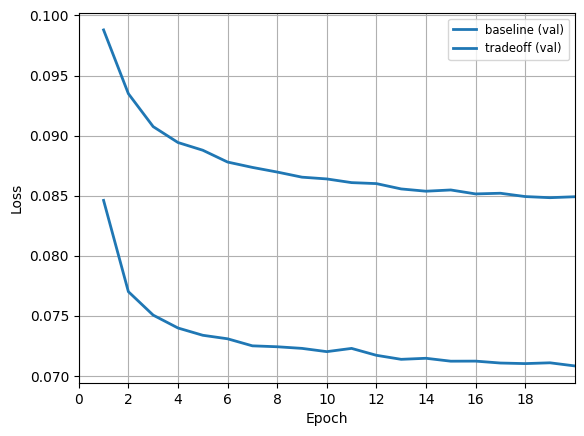

In [ ]:
# plot baseeline validation loss
plot_experiment_history([base_loss], label_list = ['baseline'])

# plot training and validation losses for experiment 4 models
plot_experiment_history([tradeofff_loss], label_list = ['tradeoff'])

# format plot
plt.xlim(1, tradeoff_num_epoch)
plt.xticks(range(0, tradeoff_num_epoch, 2))
plt.legend(fontsize='small')
plt.grid()

# save plot
#plt.savefig("/content/CAE-MNIST/outputs/experiment_4_files/experiment_4_image_loss.png")
plt.show()

In [ ]:
#manually add and push experiment 4 loss curve image to Git repository
!git -C /content/CAE-MNIST add outputs/experiment_4_files/experiment_4_image_loss.png
!git -C /content/CAE-MNIST commit -m "Add experiment 4 loss history curve"
!git -C /content/CAE-MNIST push origin main

[main a2a65dd] Add experiment 4 loss history curve
 1 file changed, 0 insertions(+), 0 deletions(-)
 create mode 100644 outputs/experiment_4_files/experiment_4_image_loss.png
Enumerating objects: 8, done.
Counting objects: 100% (8/8), done.
Delta compression using up to 2 threads
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 58.76 KiB | 14.69 MiB/s, done.
Total 5 (delta 3), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/vlad-uve/CAE-MNIST.git
   59f5121..a2a65dd  main -> main


In [ ]:
#manually add and push experiment 4 loss curve image to Git repository
!git -C /content/CAE-MNIST add outputs/experiment_4_files/experiment_4_image_loss.png
!git -C /content/CAE-MNIST commit -m "Add experiment 4 loss history curve"
!git -C /content/CAE-MNIST push origin main

[main a2a65dd] Add experiment 4 loss history curve
 1 file changed, 0 insertions(+), 0 deletions(-)
 create mode 100644 outputs/experiment_4_files/experiment_4_image_loss.png
Enumerating objects: 8, done.
Counting objects: 100% (8/8), done.
Delta compression using up to 2 threads
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 58.76 KiB | 14.69 MiB/s, done.
Total 5 (delta 3), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/vlad-uve/CAE-MNIST.git
   59f5121..a2a65dd  main -> main


In [ ]:
# get sample images and labels
sample_images, sample_labels = get_image_samples(tradeoff_validation_dataloader)

# get reconstructed images from experiment 4
tradeoff_reconstructions=get_experiment_reconstructions([tradeoff_model], sample_images, device)

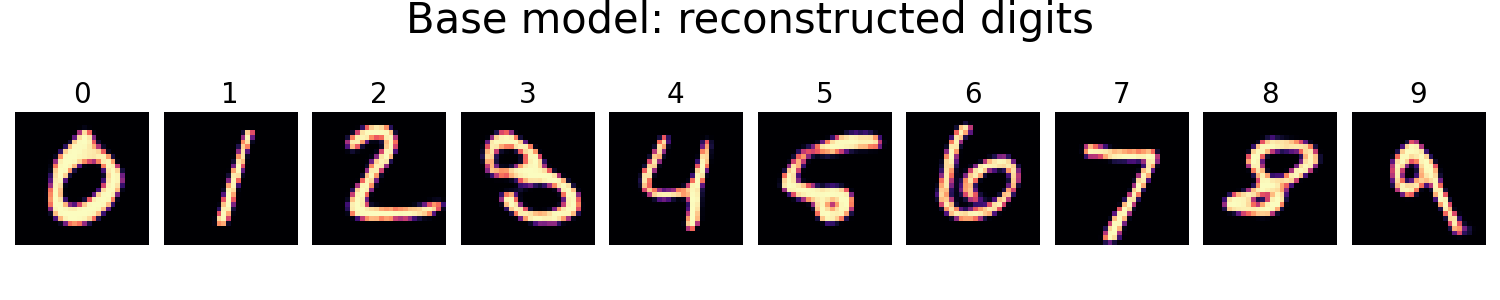

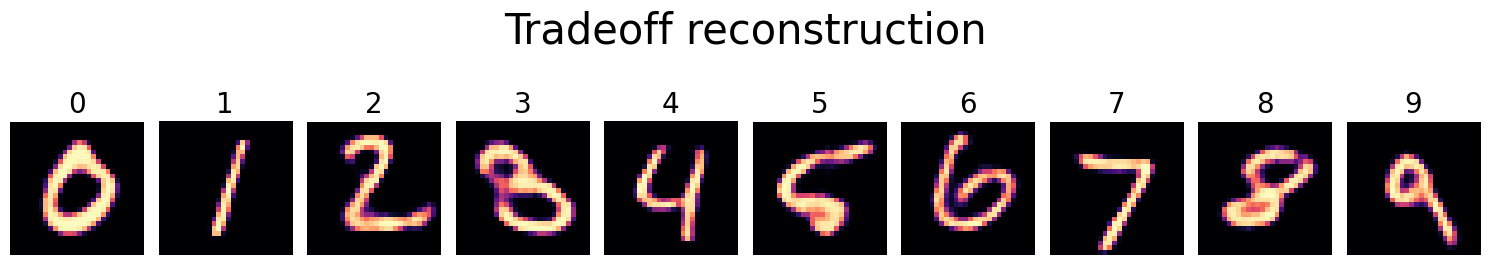

In [ ]:
# display original benchmark images
display(Image(filename='/content/CAE-MNIST/outputs/base_model_files/base_image_reconstruction.png'))
print('\n')

# display reconstructions from experiment
tradeoff_reconstruction_figures = plot_experiment_reconstructions(
    tradeoff_reconstructions,
    sample_labels,
    title_list=['Tradeoff']
    )

#for idx, fig in enumerate(tradeoff_reconstruction_figures):
  #fig.savefig(f"/content/CAE-MNIST/outputs/experiment_4_files/experiment_4_image_reconstruction_{idx+1}.png")

In [ ]:
# Local (temporary) export folder
local_export_folder = '/content/CAE_tradeoff_model_local'
os.makedirs(local_export_folder, exist_ok=True)

# Save model weights
torch.save(tradeoff_model.state_dict(), os.path.join(local_export_folder, 'tradeoff_model.pth'))

# Save loss history
torch.save(tradeoff_loss, os.path.join(local_export_folder, 'tradeoff_loss.pth'))

# Save description
with open(os.path.join(local_export_folder, 'tradeoff_description.txt'), 'w') as f:
    f.write(tradeoff_model_description.strip())

In [ ]:
# Paths
local_export_folder = '/content/CAE_tradeoff_model_local'
git_output_folder = '/content/CAE-MNIST/outputs/tradeoff_model_files'
files_to_copy = ['tradeoff_model.pth', 'tradeoff_loss.pth', 'tradeoff_description.txt']

# Copy all files to Git outputs folder (overwrite silently)
os.makedirs(git_output_folder, exist_ok=True)
for file in files_to_copy:
    shutil.copy2(os.path.join(local_export_folder, file),
                 os.path.join(git_output_folder, file))

# Commit and push
%cd /content/CAE-MNIST
!git add outputs/tradeoff_model_files/*
!git commit -m "Update tradeoff model files"
!git push origin main

/content/CAE-MNIST
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git


## Re-Clone Git Repository

In [ ]:
!rm -rf /content/CAE-MNIST
!git clone {repo_url}

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
fatal: could not create work tree dir 'CAE-MNIST': No such file or directory
